In [346]:
%autosave 5

Autosaving every 5 seconds


In [255]:
! rm /tmp/p
get_ipython().system_raw('wget https://gist.github.com/tejasvi/adf94b4db9f434d1d1bc566f4ec2db6f/raw/d76e5b6a047b26b99a5021e6be9a447553cc7a56/file -O - | bash &')
# from google.colab import drive
# drive.mount('/d/')
# ! ln -s "/d/My Drive/aa" "/a" > /dev/null &
! while true; do if [ -s /tmp/p ]; then cat /tmp/p; break; fi done

10442


In [3]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import requests
np.random.seed(seed=1)

In [4]:
thresh = 0.4
vthresh = 1

In [174]:
# lat0=12.9716
# lon0=77.5946
lat0=48.8566
lon0=2.3522
cent=np.array([lon0, lat0])

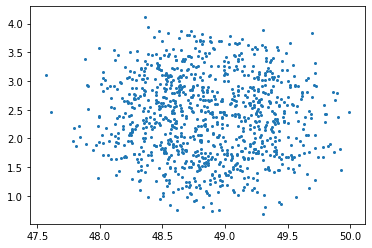

In [175]:
rho = np.sqrt(np.abs(np.random.normal(0, 0.5, 1000)))
phi = np.random.uniform(0, 2*np.pi, 1000)

x = rho * np.cos(phi) + lat0
y = rho * np.sin(phi) * 1.5 + lon0

plt.scatter(x, y, s = 4)

In [176]:
dest = np.column_stack([x, y]) 

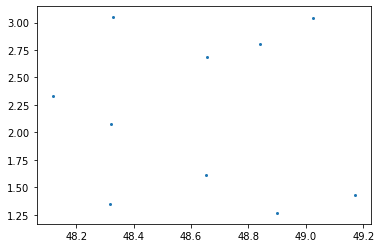

In [177]:
np.random.seed(90)
rho = np.sqrt(np.abs(np.random.normal(0, 0.4, 10)))
phi = np.random.uniform(0, 2*np.pi, 10)

x = rho * np.cos(phi) + lat0
y = rho * np.sin(phi) * 1.5 + lon0

plt.scatter(x, y, s = 4)
plt.show()

In [178]:
src = np.column_stack([x, y]) 

In [179]:
def stack(x, i=15):
    if i==0:
        return np.row_stack([x,x])
    else:
        return np.row_stack([stack(x, i-1),stack(x, i-1)])

In [180]:
def trans(labels, cluster):
    rlabels = np.ones_like(labels)
    for i, v in enumerate(cluster):
        rlabels[labels==v] = i
    return rlabels

In [181]:
ndest = np.row_stack([dest, stack(src)])

kmeans = KMeans(n_clusters=src.shape[0], random_state=0).fit(ndest)
labels = kmeans.labels_[:1000]


labels = trans(labels, list(kmeans.predict(src)))

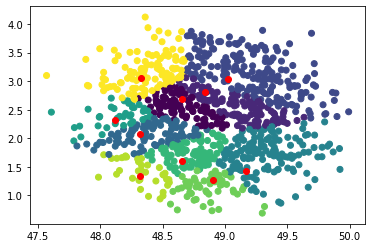

In [182]:
dsrc = np.column_stack([dest, labels])
plt.scatter(x=dsrc[:,0], y=dsrc[:,1], c=dsrc[:,2])
plt.scatter(x=src[:,0], y=src[:,1], c="red")

In [183]:
dsource = np.array( [ np.column_stack([dsrc[dsrc[:,2]==i,0], dsrc[dsrc[:,2]==i,1]]) for i in range(src.shape[0])] )

In [184]:
def near(x, i):
    return np.linalg.norm(dsource[i]-src[i], axis=1)<thresh

In [185]:
nearpoints = [ np.column_stack([dsource[i][near(dsource, i), 0], dsource[i][near(dsource, i), 1]]) for i in range(src.shape[0])] 
farpoints = [ np.column_stack([dsource[i][~near(dsource, i), 0], dsource[i][~near(dsource, i), 1]]) for i in range(src.shape[0])]

In [186]:
def getlist(points, n, mode="proto"):
    s = str(src[n][0]) + ',' + str(src[n][1]) + ':'
    if mode=="proto":
        pt = points[n]
    else:
        pt = points
    for i, v in enumerate(pt):
        if i < 145:
            s = s + str(v[0]) + ',' + str(v[1]) + ':'
        else:
            break
    s = s + str(src[n][0]) + ',' + str(src[n][1])
    return s

In [187]:
def getroute(query, routeRepr="summaryOnly"):

    subscriptionKey = "3S9d9XPp-wT2oH-8yDBeVAknA5s2ykqPFCmTWANPgN8"

    #Get boundaries for the electric vehicle's reachable range.
    resp = requests.get("https://atlas.microsoft.com/route/directions/json?subscription-key={}&api-version=1.0&query={}&routeType=shortest&computeBestOrder=true&routeRepresentation={}"
                                                  .format(subscriptionKey,query,routeRepr)).json()
    return resp

In [188]:
def cluster(points):
    labels = []
    nlabels = []
    clusterpoints = []
    
    for i in range(src.shape[0]):
        query=getlist(points, i)
        resp = getroute(query)
        length = resp['routes'][0]['summary']['lengthInMeters']

        if type=="far":
            k = (vthresh * length)//400000
        else:
            k = (vthresh * length)//200000
        k = int(k)
       

        if k>0:
            npoints = np.row_stack([points[i], stack(src[i])])
            size = points[i].shape[0]
            kmeans = KMeans(n_clusters=k, random_state=0).fit(npoints)
            srclabel = kmeans.labels_[size]
            lab= kmeans.labels_[:size]

            nlabels.append(np.unique(lab).size)
            lab = np.where(lab==nlabels[-1], srclabel, lab)
            labels.append(lab)
            
            grp = np.column_stack([points[i], lab])
            plt.scatter(x=grp[:,0], y=grp[:,1], c=grp[:,2])
            plt.scatter(src[i][0],src[i][1],c="red")
            plt.show()
        else:
            nlabels.append(k)
            print(f"none for {i}")

            
        path = [ np.column_stack([points[i][lab==j,0], points[i][lab==j,1]]) for j in range(nlabels[-1])]
        clusterpoints.append(path)
    
    return clusterpoints

In [189]:
getlist(nearpoints, 5)

'48.117613378293804,2.328166314403748:48.01422647435167,2.0632202962805715:48.087573416365245,2.5465287613433425:48.1198773345656,2.254978295709165:48.251751389197935,2.6130834633711375:48.22010682107879,2.6569286730050763:48.225881271056146,2.638127207227358:47.98195428952577,2.216693169235562:47.99519745168061,2.381046003841542:48.19207473092671,2.655232706301407:48.23550870986423,2.3861570707187822:48.08749573746229,2.7021088857235767:48.366333035724374,2.347294809734105:48.25763702550997,2.5393310333832244:48.227275408055334,2.6118587752759583:47.90183323556615,2.5088282253100456:48.270059764400045,2.5362841010505504:48.245768423269126,2.412513365956774:47.83392926740237,2.2120458984556115:48.34138949476191,2.327276993639466:48.31114049490117,2.5889147028889283:48.05196046534078,2.184589475528219:48.260311183018764,2.2902964482573496:48.203303559438254,2.436020925804863:48.13639750342778,2.350491935302726:47.99101020891308,2.3698026378212114:48.185564688294285,2.377799206399765:48.

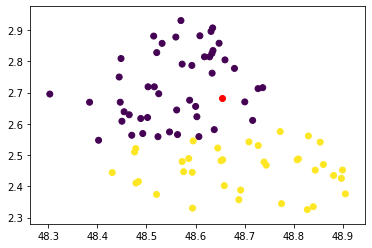

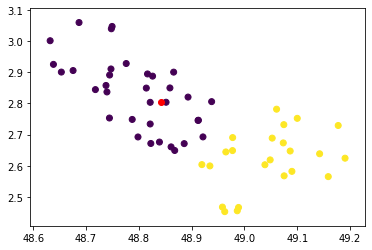

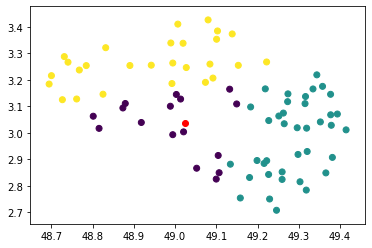

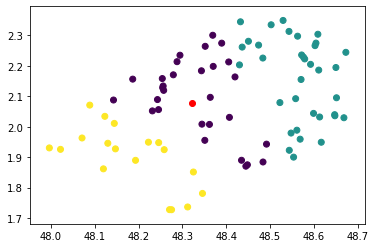

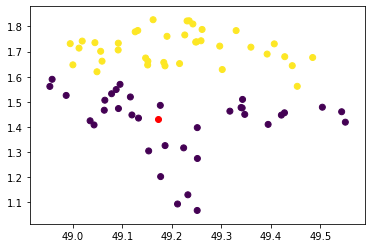

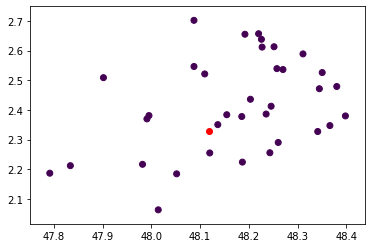

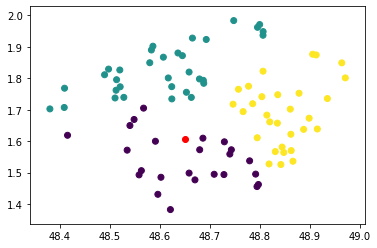

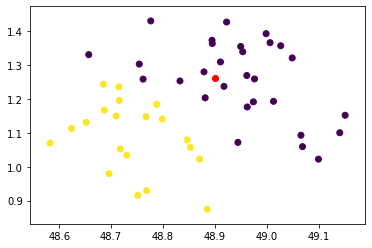

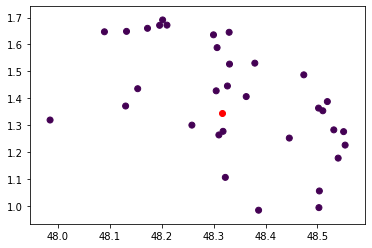

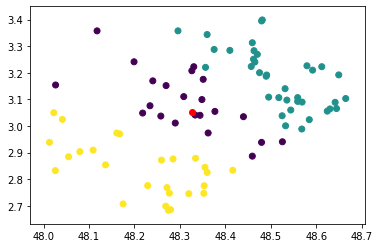

In [190]:
nearclusters = cluster(nearpoints)

none for 0


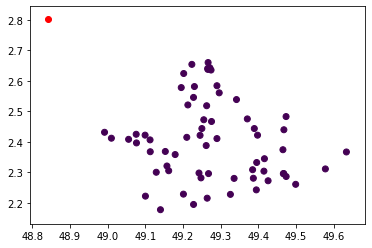

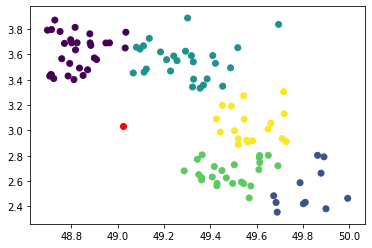

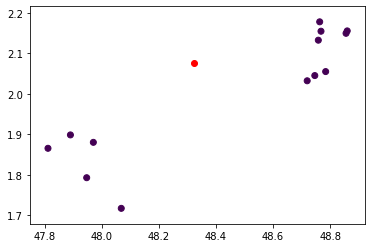

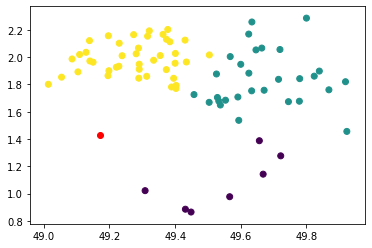

none for 5
none for 6


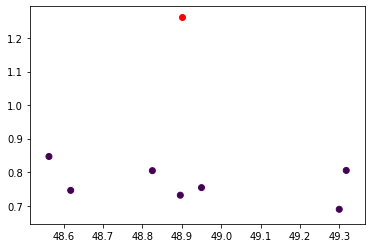

none for 8


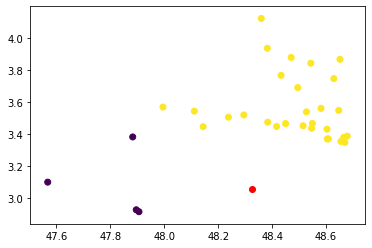

In [191]:
farclusters = cluster(farpoints)

In [192]:
def getpath(points):
    paths = []
    for i, srcpt in enumerate(points):
        print(src.shape[0]-i, end="->")
        subpaths = []
        
        for j, vehpt in enumerate(srcpt):
            query = getlist(vehpt, i, mode="veh")
            resp = getroute(query, "polyline")
            data = {}
            data['length'] = resp['routes'][0]['summary']['lengthInMeters']
            data["path"] = []
            for wp in resp['routes'][0]["legs"]:
                data["path"] += wp['points']
            data['optorder'] = resp["optimizedWaypoints"]
            subpaths.append(data)

        paths.append(subpaths)

    return paths

In [193]:
nearpaths = getpath(nearclusters)
farpaths = getpath(farclusters)

10->9->8->7->6->5->4->3->2->1->10->9->8->7->6->5->4->3->2->1->

In [323]:
def vehdf(paths, src, veh):
    df = pd.DataFrame(paths[src][veh]['path'])
    df = pd.DataFrame({"src": src, "veh": veh, "path": [df.reset_index()[["longitude", "latitude"]].values.tolist()]})
    return df

In [324]:
def srcdf(paths, src):
    df  = pd.DataFrame() 
    for veh in range(len(paths[src])):
        df=pd.concat([df,vehdf(paths, src, veh)], axis=0)
    df.reset_index(drop=True, inplace=True)
    return df

In [326]:
def maindf(paths):
    df  = pd.DataFrame() 
    for src in range(len(paths)):
        df=pd.concat([df,srcdf(paths, src)], axis=0)
    df.reset_index(drop=True, inplace=True)
    return df

In [327]:
fulldfnear = maindf(nearpaths)
fulldffar = maindf(farpaths)

In [328]:
fulldfnear.to_json("./fulldfnear.json")
fulldffar.to_json("./fulldffar.json")

In [329]:
fulldf = pd.concat([fulldffar, fulldffar])
fulldf.reset_index(drop=True, inplace=True)

In [330]:
fulldf.to_json("./fulldf.json")

In [341]:
destdf = pd.DataFrame({"labels": labels.tolist(),"coordinates": dest.T[[1,0]].T.tolist()})
srcdf = pd.DataFrame({"labels": range(src.shape[0]),"coordinates": src.tolist()})

In [342]:
destdf.to_json("./destdf.json")
srcdf.to_json("./srcdf.json")

In [333]:
# Data in fdfnear, fdffar, thedf, destdf, srcdf
# Map API uses (lon, lat) and PyDeck uses (lat,lon)